# Send Custom Metrics and Test Results

In [2]:
%load_ext dotenv
%dotenv dev.env

import validmind as vm

vm.init(
  api_host = "http://localhost:3000/api/v1/tracking",
  # Use your project ID
  project = "..."
)
  

True

## Send Custom Metrics

It is possible to send custom metrics to ValidMind without implementing a `Metric` class. The only requirement is to construct an instance of a `MetricResult`
that can be sent to the ValidMind API.

In [3]:
from validmind.vm_models import MetricResult

accuracy_metric = MetricResult(
    type="evaluation",
    scope="test_dataset",    
    key="my_custom_accuracy",
    value=0.666
)

In [4]:
vm.log_metrics([accuracy_metric])

True

## Send Custom Test Results

It is possible to send custom test results to ValidMind without implementing a `ThresholdTest` class. The only requirement is to construct an instance of a `TestResults`
that can be sent to the ValidMind API.

In [5]:
from validmind.vm_models import TestResult, TestResults

custom_params = {
    "min_percent_threshold": 0.5
}

custom_test_result = TestResults(
    category="model_performance",
    test_name="accuracy_threshold",
    params=custom_params,
    passed=False,
    results=[
        TestResult(
            passed=False,
            values={
                "score": 0.15,
                "threshold": custom_params["min_percent_threshold"],
            },
        )
    ],
)

In [6]:
vm.log_test_results([custom_test_result])

True

## Implementing Custom Metrics or ThresholdTests

It is possible to implement custom metrics or threshold test classes. The are only two requirements for getting this to work:

- We need to build a `TestPlan` that can execute the custom metric or threshold test (or add it to an existing `TestPlan`, TBD).
- We need to implement a `run` method on the custom metric or threshold test class.

### Implementing a Custom Metric

The following example shows how to implement a custom metric that calculates the mean of a list of numbers.

In [7]:
from dataclasses import dataclass
from validmind.vm_models import Metric

@dataclass
class MeanMetric(Metric):
    type = "dataset"
    key = "mean_of_values"

    def run(self):
        if "values" not in self.params:
            raise ValueError("values must be provided in params")

        if not isinstance(self.params["values"], list):
            raise ValueError("values must be a list")
        
        values = self.params["values"]
        mean = sum(values) / len(values)
        return self.cache_results(mean)

### Testing the Custom Metric

It is possible to run a custom metric without running an entire test plan. This is useful for testing the metric before integrating it into a test plan.

The key idea is to create a `TestContext` object and pass it to the metric initializer. When a test plan is executed, the `TestContext` is created by the `TestPlan` class and passed down to every associated metric and threshold test. However, when we want to test a metric in isolation, we need to create the `TestContext` ourselves.

In this example we don't need to pass any arguments to the `TestContext` initializer, but it is possible to pass any arguments as required by `required_inputs`.

In [8]:
from validmind.vm_models.test_context import TestContext

test_context = TestContext()
mean_metric = MeanMetric(test_context=test_context, params={
    "values": [1, 2, 3, 4, 5]
})
mean_metric.run()

TestPlanMetricResult(figures=None, metric=MetricResult(type='dataset', scope='', key='mean_of_values', value=3.0, value_formatter=None))

We can also inspect the results of the metric by accessing the `result` variable:

In [9]:
mean_metric.result

TestPlanMetricResult(figures=None, metric=MetricResult(type='dataset', scope='', key='mean_of_values', value=3.0, value_formatter=None))

In [10]:
mean_metric.result.metric.value

3.0

In [11]:
mean_metric.result.show()

### Implementing a Custom ThresholdTest

The following example shows how to implement a custom threshold test that fails if the mean of a list of numbers is greater than 5.

In [12]:
from dataclasses import dataclass
from validmind.vm_models import ThresholdTest

@dataclass
class MeanThresholdTest(ThresholdTest):
    category = "data_quality"
    name = "mean_threshold"
    default_params = {"mean_threshold": 5}    

    def run(self):
        if "values" not in self.params:
            raise ValueError("values must be provided in params")

        if not isinstance(self.params["values"], list):
            raise ValueError("values must be a list")
        

        values = self.params["values"]
        mean = sum(values) / len(values)        

        passed = mean <= self.params["mean_threshold"]
        results = [
            TestResult(
                passed=passed,
                values={
                    "mean": mean,
                    "values": values,
                },
            )
        ]

        return self.cache_results(results, passed=passed)

### Testing the Custom Threshold Test

Similarly to custom metrics, it is also possible to run a custom threshold test without running an entire test plan:

In [13]:
from validmind.vm_models.test_context import TestContext

test_context = TestContext()
mean_threshold_test = MeanThresholdTest(test_context=test_context, params={
    "values": [1, 2, 3, 4, 5]
})
mean_threshold_test.run()

TestPlanTestResult(figures=None, test_results=TestResults(category='data_quality', test_name='mean_threshold', params={'mean_threshold': 5, 'values': [1, 2, 3, 4, 5]}, passed=True, results=[TestResult(test_name=None, column=None, passed=True, values={'mean': 3.0, 'values': [1, 2, 3, 4, 5]})]))

In [14]:
test_results = mean_threshold_test.test_results.test_results
test_results.passed

True

In [15]:
for result in test_results.results:
    print(f"passed: {result.passed}, values: {result.values}")

passed: True, values: {'mean': 3.0, 'values': [1, 2, 3, 4, 5]}


### Implementing a Custom TestPlan

The following example shows how to implement a custom test plan that executes the custom metric and threshold test.

In [16]:
from validmind.vm_models import TestPlan

class MyCustomTestPlan(TestPlan):
    """
    Custom test plan
    """

    name = "my_custom_test_plan"
    required_inputs = []
    tests = [MeanMetric, MeanThresholdTest]

my_custom_test_plan = MyCustomTestPlan(config={
    "mean_of_values": {
        "values": [1, 2, 3, 4, 5]
    },
    "mean_threshold": {
        "values": [6, 7, 8, 9, 10]
    }
})
my_custom_test_plan.run()

## Registering a Custom TestPlan

It is possible to register a custom test plan with ValidMind. This allows us to run the test plan using the same ValidMind Python API and combine it with other test plans as needed.

In [17]:
vm.test_plans.register_test_plan("my_custom_test_plan", MyCustomTestPlan)

Registered test plan: my_custom_test_plan


In [18]:
vm.run_test_plan("my_custom_test_plan", config={
    "mean_of_values": {
        "values": [1, 2, 3, 4, 5]
    },
    "mean_threshold": {
        "values": [6, 7, 8, 9, 10]
    }
})

## Send Figures with Metrics and Test Results

It is possible to send figures with metrics and test results. The following example shows how to send a figure with a metric result.

### Sending Figures with Custom Metrics

Let's say we want to add a figure to our custom metric above. We can do this by adding a `figures` attribute to the `cache_results` method call. Let's modify our custom metric code to do that.

In [19]:
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np

from validmind.vm_models import Figure, Metric

@dataclass
class MeanMetricWithFigure(Metric):
    type = "dataset"
    key = "mean_of_values_with_figure"

    def run(self):
        if "values" not in self.params:
            raise ValueError("values must be provided in params")

        if not isinstance(self.params["values"], list):
            raise ValueError("values must be a list")
        
        values = self.params["values"]
        mean = sum(values) / len(values)

        # Create a random histogram with matplotlib
        fig, ax = plt.subplots()
        ax.hist(np.random.randn(1000), bins=20, color="blue")
        ax.set_title("Histogram of random numbers")
        ax.set_xlabel("Value")
        ax.set_ylabel("Frequency")

        # Do this if you want to prevent the figure from being displayed
        plt.close("all")
        
        figure = Figure(key=self.key, figure=fig, metadata={})

        return self.cache_results(mean, figures=[figure])

### Sending Figures with Custom Threshold Tests

Similarly, we can add a figure to our custom threshold test by adding a `figures` attribute to the `cache_results` method call.

In [20]:
from dataclasses import dataclass
from validmind.vm_models import Figure, ThresholdTest

@dataclass
class MeanThresholdTestWithFigure(ThresholdTest):
    category = "data_quality"
    name = "mean_threshold_with_figure"
    default_params = {"mean_threshold": 5}    

    def run(self):
        if "values" not in self.params:
            raise ValueError("values must be provided in params")

        if not isinstance(self.params["values"], list):
            raise ValueError("values must be a list")
        

        values = self.params["values"]
        mean = sum(values) / len(values)        

        passed = mean <= self.params["mean_threshold"]
        results = [
            TestResult(
                passed=passed,
                values={
                    "mean": mean,
                    "values": values,
                },
            )
        ]

        # Create a random histogram with matplotlib
        fig, ax = plt.subplots()
        ax.hist(np.random.randn(1000), bins=20, color="blue")
        ax.set_title("Histogram of random numbers")
        ax.set_xlabel("Value")
        ax.set_ylabel("Frequency")

        # Do this if you want to prevent the figure from being displayed
        plt.close("all")
        
        figure = Figure(key=self.name, figure=fig, metadata={})        

        return self.cache_results(results, passed=passed, figures=[figure])

We can now run a new test plan that includes our two new custom metrics and threshold tests.


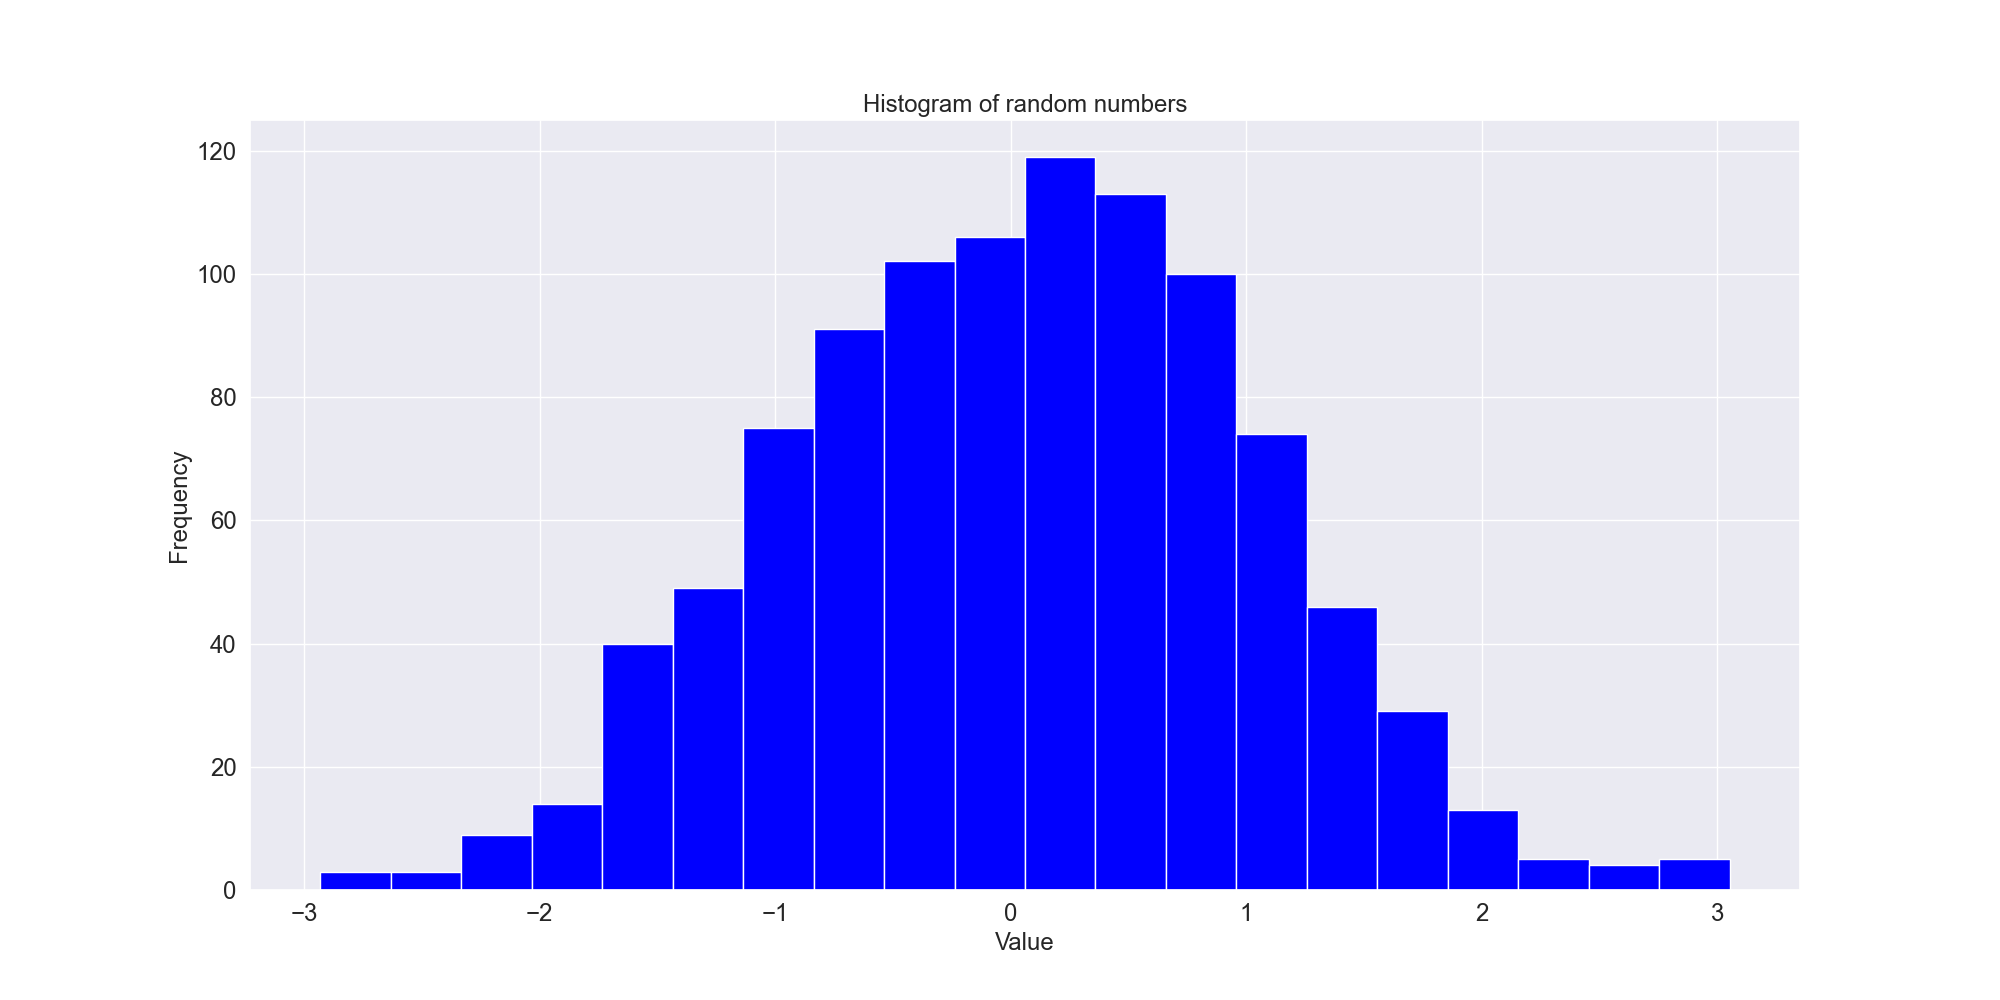
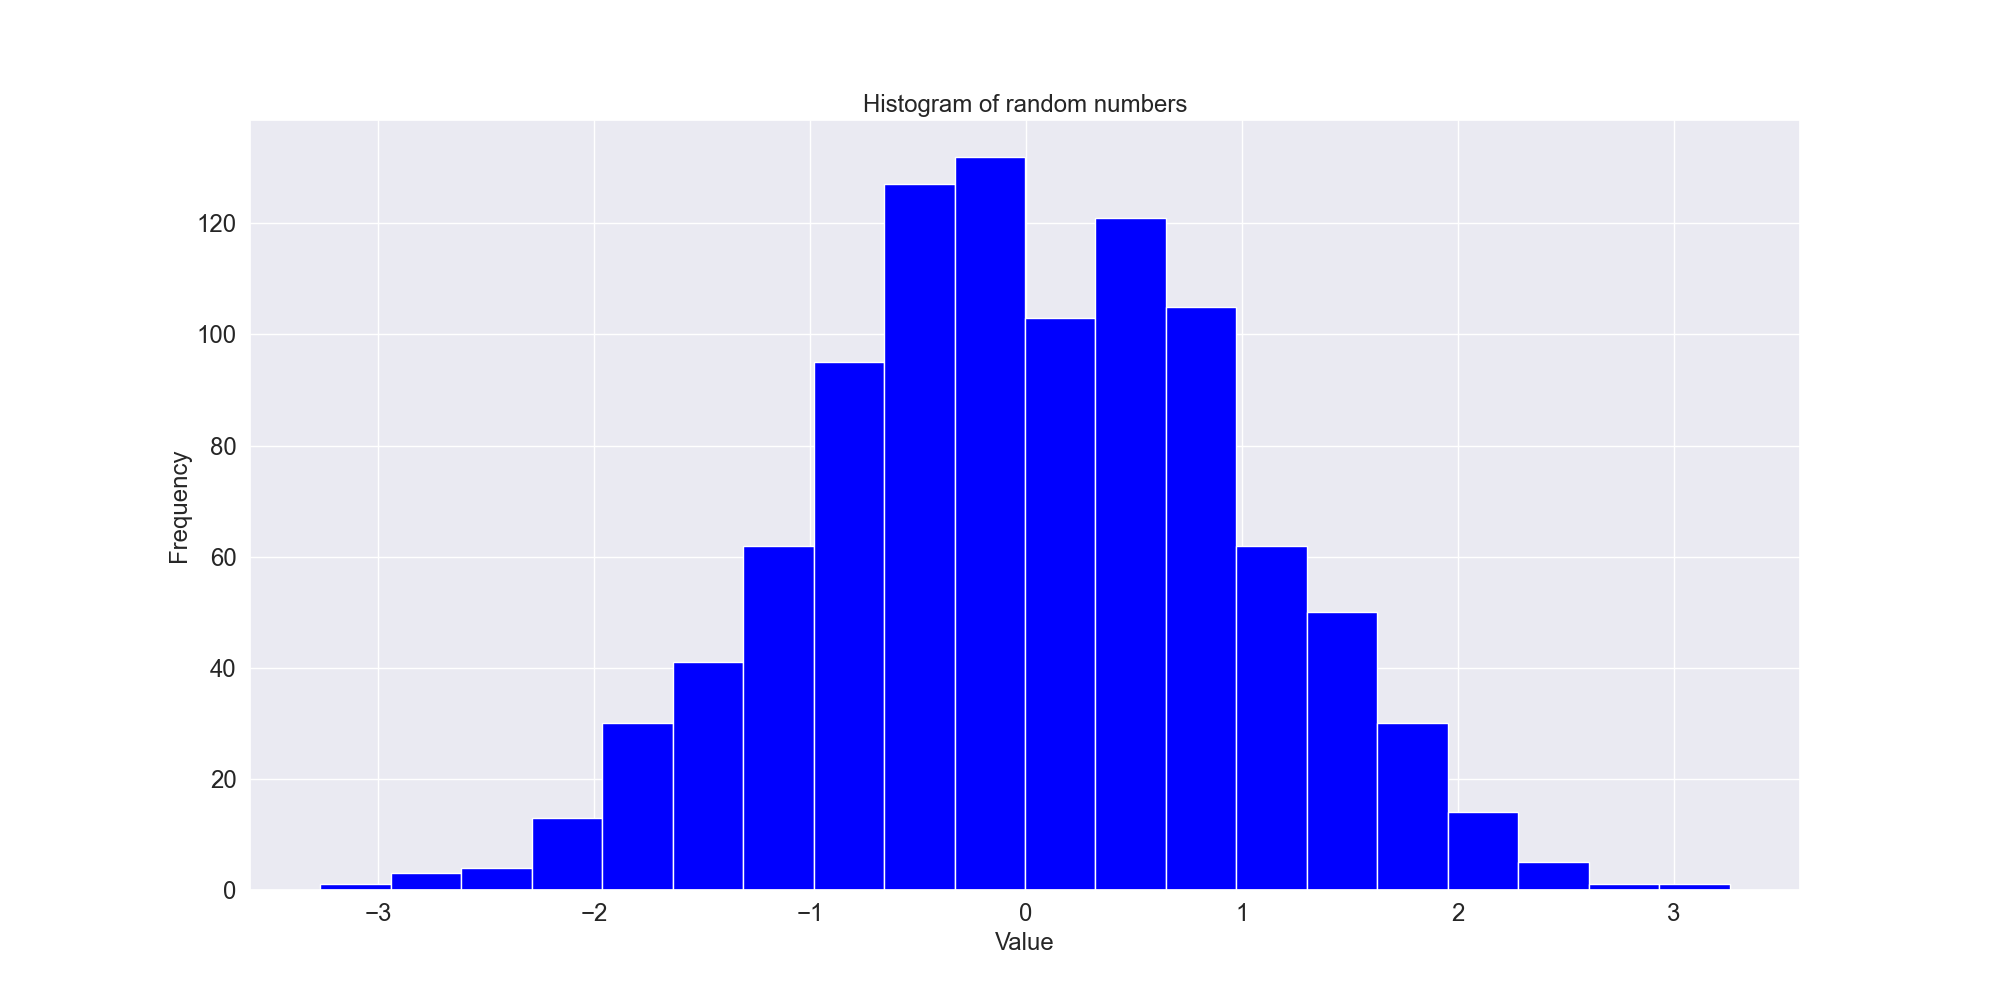

In [21]:
from validmind.vm_models import TestPlan

class MyCustomTestPlanWithFigures(TestPlan):
    """
    Custom test plan
    """

    name = "my_custom_test_plan_with_figures"
    required_inputs = []
    tests = [MeanMetricWithFigure, MeanThresholdTestWithFigure]

my_custom_test_plan_with_figures = MyCustomTestPlanWithFigures(config={
    "mean_of_values_with_figure": {
        "values": [1, 2, 3, 4, 5]
    },
    "mean_threshold_with_figure": {
        "values": [6, 7, 8, 9, 10]
    }
})
my_custom_test_plan_with_figures.run()